# Exploratory Data Analysis

# Setup

In [1]:
import pandas as pd
import janitor
import os
import sys
from dotenv import load_dotenv
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import random

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from eda_utils import add_gbp_columns, explode_lists, get_longest_values, print_in_rows, check_names, nd, check_overlap
from stats_builder import make_summary_df, calculate_stats, make_calculated_df, format_stats, format_df
from plots_builder import make_bar_chart, make_histograms
from utils import get_table_from_supabase

#get keys from env
load_dotenv()
url = os.getenv("SUPABASE_URL")
key = os.getenv("SUPABASE_KEY")

# Retrieving Data from Supabase and Building Dataframes

I will connect to Supabase and retrieve all records, in order to start building my analysis dataframes. I will create one dataframe for funder information, and another for grants and recipients information.

In [2]:
#get tables and build dataframes
tables = ["funders", "causes", "areas", "beneficiaries", "grants",
               "funder_causes", "funder_areas", "funder_beneficiaries", "funder_grants", 
               "financials", "funder_financials"]

for table in tables:
    globals()[table] = get_table_from_supabase(url, key, table)

#get recipients with filter
recipients = get_table_from_supabase(url, key, "recipients", batch_size=50, filter_recipients=True)
all_recipient_ids = set(recipients["recipient_id"].unique())

#get and filter recipient join tables
recipient_join_tables = ["recipient_grants", "recipient_areas", "recipient_beneficiaries", "recipient_causes"]
for table in recipient_join_tables:
    df = get_table_from_supabase(url, key, table)
    globals()[table] = df[df["recipient_id"].isin(all_recipient_ids)]

print(f"Loaded {len(funders)} funders, {len(recipients)} recipients, {len(grants)} grants")
print(f"Filtered recipient join tables to {len(all_recipient_ids)} valid recipients")

Loaded 996 funders, 18532 recipients, 32816 grants
Filtered recipient join tables to 18532 valid recipients


## The Funders Dataframe

### Main Table

In [3]:
funders_df = funders.copy()

#define table relationships for funders
funder_rels = [
    {
        "join_table": funder_causes,
        "lookup_table": causes,
        "key": "cause_id",
        "value_col": "cause_name",
        "result_col": "causes"
    },
    {
        "join_table": funder_areas,
        "lookup_table": areas,
        "key": "area_id",
        "value_col": "area_name",
        "result_col": "areas"
    },
    {
        "join_table": funder_beneficiaries,
        "lookup_table": beneficiaries,
        "key": "ben_id",
        "value_col": "ben_name",
        "result_col": "beneficiaries"
    }
]

#group and merge
for rel in funder_rels:
    grouped = rel["join_table"].merge(rel["lookup_table"], on=rel["key"])
    grouped = grouped.groupby("registered_num")[rel["value_col"]].apply(list).reset_index()
    grouped.columns = ["registered_num", rel["result_col"]]
    funders_df = funders_df.merge(grouped, on="registered_num", how="left")

#add grant statistics columns 
grants_stats = funder_grants.merge(grants, on="grant_id")
grants_agg = grants_stats.groupby("registered_num").agg({
    "grant_id": "count",
    "amount": ["sum", "mean", "median"]
}).reset_index()
grants_agg.columns = ["registered_num", "num_grants", "total_given", "avg_grant", "median_grant"]

funders_df = funders_df.merge(grants_agg, on="registered_num", how="left")
funders_df["num_grants"] = funders_df["num_grants"].astype("Int64")

#replace nan values with empty lists
funders_df["causes"] = funders_df["causes"].apply(lambda x: x if isinstance(x, list) else [])
funders_df["areas"] = funders_df["areas"].apply(lambda x: x if isinstance(x, list) else [])
funders_df["beneficiaries"] = funders_df["beneficiaries"].apply(lambda x: x if isinstance(x, list) else [])

#round to 2 decimal places
funders_df = funders_df.round(2)
pd.set_option("display.float_format", "{:.2f}".format)

#format financial columns
float_cols = ["income_latest", "expenditure_latest", "total_given", "avg_grant", "median_grant"]
for col in float_cols:
    if col in funders_df.columns:
        funders_df[col + "_gbp"] = funders_df[col].apply(add_gbp_columns)

### Financial History Table

In [4]:
#get full financial records and separate into income and expenditure
financial_history = funder_financials.merge(financials, on="financials_id")
income_history = financial_history[financial_history["financials_type"] == "income"]
expenditure_history = financial_history[financial_history["financials_type"] == "expenditure"]

#make financials dicts
income_by_funder = income_history.groupby("registered_num").apply(
    lambda x: dict(zip(x["financials_year"], x["financials_value"]))
).reset_index()
income_by_funder.columns = ["registered_num", "income_history"]

expenditure_by_funder = expenditure_history.groupby("registered_num").apply(
    lambda x: dict(zip(x["financials_year"], x["financials_value"]))
).reset_index()
expenditure_by_funder.columns = ["registered_num", "expenditure_history"]

#merge with funders and replace nans
funders_df = funders_df.merge(income_by_funder, on="registered_num", how="left")
funders_df = funders_df.merge(expenditure_by_funder, on="registered_num", how="left")
funders_df["income_history"] = funders_df["income_history"].apply(lambda x: x if isinstance(x, dict) else {})
funders_df["expenditure_history"] = funders_df["expenditure_history"].apply(lambda x: x if isinstance(x, dict) else {})

### The List Entries

In [5]:
#get list entries
list_entries = get_table_from_supabase(url, key, "list_entries")
funder_list = get_table_from_supabase(url, key, "funder_list")
list_with_info = funder_list.merge(list_entries, on="list_id")

#get list of entries for each funder
list_grouped = list_with_info.groupby("registered_num")["list_info"].apply(list).reset_index()
list_grouped.columns = ["registered_num", "list_entries"]

#merge with funders and replace nans
funders_df = funders_df.merge(list_grouped, on="registered_num", how="left")
funders_df["list_entries"] = funders_df["list_entries"].apply(lambda x: x if isinstance(x, list) else [])

In [6]:
#extend column view, sort and preview funders
pd.set_option("display.max_columns", 100)
funders_df = funders_df.sort_values("total_given_gbp", ascending=False)
funders_df.head()

,registered_num,name,website,activities,objectives,income_latest,expenditure_latest,objectives_activities,achievements_performance,grant_policy,is_potential_sbf,is_on_list,causes,areas,beneficiaries,num_grants,total_given,avg_grant,median_grant,income_latest_gbp,expenditure_latest_gbp,total_given_gbp,avg_grant_gbp,median_grant_gbp,income_history,expenditure_history,list_entries
820,288086,FARRER AND CO CHARITABLE TRUST,https://www.farrer.co.uk,THE MAIN PURPOSE OF THE TRUST IS TO APPLY INCO...,IN OR TOWARDS THE GENERAL PURPOSES OF SUCH CHA...,80569.00,78229.00,None,None,None,False,False,[General Charitable Purposes],[Throughout England And Wales],[Other Charities Or Voluntary Bodies],14,97590.14,6970.72,4000.00,"£80,569.00","£78,229.00","£97,590.14","£6,970.72","£4,000.00","{2020: 78285.0, 2021: 52439.0, 2022: 79299.0, ...","{2020: 76431.0, 2021: 61395.0, 2022: 76795.0, ...",[]
897,1041449,MIRACLES,https://www.miraclesthecharity.org,MIRACLES IS A CHARITY OFFERING HOPE FOR THOSE ...,THE RELIEF OF POVERTY AND HARDSHIP OF PERSONS ...,351143.00,908121.00,THE AIMS AND OBJECTS OF MIRACLES REMAIN TO PRO...,THIRTY-ONE YEARS ON SINCE THE LAUNCH OF MIRACL...,None,False,False,"[General Charitable Purposes, Education/traini...","[Scotland, Europe, Throughout England]",[The General Public/mankind],8,96073.00,12009.12,2750.00,"£351,143.00","£908,121.00","£96,073.00","£12,009.12","£2,750.00","{2020: 235183.0, 2021: 325035.0, 2022: 303775....","{2020: 322068.0, 2021: 337276.0, 2022: 274309....",[]
832,526956,KELSICK'S EDUCATIONAL FOUNDATION,https://www.kelsick.org.uk,TO PROVIDE GRANTS FOR EDUCATIONAL NEEDS TO YOU...,"1)THE PROVISION OF SPECIAL BENEFITS, OF ANY KI...",411338.00,408717.00,THE NET OPERATING SURPLUS FOR THE YEAR WAS NEA...,THE NET OPERATING SURPLUS FOR THE YEAR WAS NEA...,None,False,False,[Education/training],[Cumbria],"[Children/young People, People With Disabiliti...",17,956424.00,56260.24,58800.00,"£411,338.00","£408,717.00","£956,424.00","£56,260.24","£58,800.00","{2020: 416991.0, 2021: 387390.0, 2022: 407536....","{2020: 408890.0, 2021: 381641.0, 2022: 382351....",[]
806,260741,A P TAYLOR TRUST,https://www.aptaylortrust.org.uk,THE YEARLY INCOME OF THE FUND PROVIDED BY THE ...,FUND FOR THE USE OF THE INHABITANTS OF THE PAR...,111430.00,136811.00,OBJECTS AND AIMS THE YEARLY INCOME OF THE FUND...,None,"DURING THE YEAR, A TOTAL AMOUNT OF £36,450 WAS...",False,False,"[General Charitable Purposes, The Advancement ...","[Hillingdon, Greater London]","[Children/young People, Elderly/old People, Pe...",75,95240.00,1269.87,300.00,"£111,430.00","£136,811.00","£95,240.00","£1,269.87",£300.00,"{2020: 112954.0, 2021: 105886.0, 2022: 98342.0...","{2020: 114393.0, 2021: 124987.0, 2022: 114089....",[]
102,270718,FRANCIS COALES CHARITABLE FOUNDATION,https://franciscoales.co.uk,TO ASSIST WITH GRANTS FOR THE STRUCTURAL REPAI...,TO PROVIDE FUNDS DIRECTLY OR BY WAY OF GRANT O...,117420.00,118765.00,THE OBJECT OF THE FOUNDATION IS TO ASSIST WITH...,"IN 2024, 22 (2023: 25) APPLICATIONS WERE CONSI...",None,False,False,[Environment/conservation/heritage],"[Buckinghamshire, Hertfordshire, Northamptonsh...",[Other Defined Groups],3,93953.00,31317.67,5000.00,"£117,420.00","£118,765.00","£93,953.00","£31,317.67","£5,000.00","{2020: 111553.0, 2021: 134468.0, 2022: 149302....","{2020: 129452.0, 2021: 132270.0, 2022: 120004....",[]


## The Grants Dataframe

### Main Table

In [7]:
grants_df = grants.copy()

#add funder info
grants_df = grants_df.merge(funder_grants, on="grant_id")
grants_df = grants_df.merge(funders[["registered_num", "name"]], on="registered_num")
grants_df = grants_df.rename(columns={"name": "funder_name"})
grants_df = grants_df.rename(columns={"registered_num": "funder_num"})

#add recipient info  
grants_df = grants_df.merge(recipient_grants, on="grant_id")
grants_df = grants_df.merge(recipients[["recipient_id", "recipient_name", "recipient_activities"]], 
                        on="recipient_id", 
                        how="left")

#add recipient areas
recip_areas_grouped = recipient_areas.merge(areas, on="area_id")
recip_areas_grouped = recip_areas_grouped.groupby("recipient_id")["area_name"].apply(list).reset_index()
recip_areas_grouped.columns = ["recipient_id", "recipient_areas"]
grants_df = grants_df.merge(recip_areas_grouped, on="recipient_id", how="left")

#add recipient causes
recip_causes_grouped = recipient_causes.merge(causes, on="cause_id")
recip_causes_grouped = recip_causes_grouped.groupby("recipient_id")["cause_name"].apply(list).reset_index()
recip_causes_grouped.columns = ["recipient_id", "recipient_causes"]
grants_df = grants_df.merge(recip_causes_grouped, on="recipient_id", how="left")

#add recipient beneficiaries
recip_beneficiaries_grouped = recipient_beneficiaries.merge(beneficiaries, on="ben_id")
recip_beneficiaries_grouped = recip_beneficiaries_grouped.groupby("recipient_id")["ben_name"].apply(list).reset_index()
recip_beneficiaries_grouped.columns = ["recipient_id", "recipient_beneficiaries"]
grants_df = grants_df.merge(recip_beneficiaries_grouped, on="recipient_id", how="left")

#replace nan values with empty lists
if "recipient_areas" in grants_df.columns:
    grants_df["recipient_areas"] = grants_df["recipient_areas"].apply(lambda x: x if isinstance(x, list) else [])
if "recipient_causes" in grants_df.columns:
    grants_df["recipient_causes"] = grants_df["recipient_causes"].apply(lambda x: x if isinstance(x, list) else [])
if "recipient_beneficiaries" in grants_df.columns:
    grants_df["recipient_beneficiaries"] = grants_df["recipient_beneficiaries"].apply(lambda x: x if isinstance(x, list) else [])

#add source of grant
grants_df["source"] = grants_df["grant_id"].apply(lambda x: "Accounts" if str(x).startswith("2") else "360Giving")

#round to 2 decimal places
grants_df = grants_df.round(2)

#format financial columns
grants_df["amount_gbp"] = grants_df["amount"].apply(add_gbp_columns)

In [8]:
#sort and preview grants
grants_df = grants_df.sort_values("grant_title", ascending=True)
grants_df.head()

,grant_title,grant_desc,amount,year,grant_id,funder_num,funder_grants_id,funder_name,recipient_id,recipient_grants_id,recipient_name,recipient_activities,recipient_areas,recipient_causes,recipient_beneficiaries,source,amount_gbp
6305,"""A BLUE NEW DEAL FOR UK COSTAL COMMUNITIES"" PR...","TOWARDS THE COSTS OF THE 'BLUE NEW DEAL', WHIC...",90000.00,2014,360G-Ellerman-15189,263207,44987,JOHN ELLERMAN FOUNDATION,1055254,43799,NEW ECONOMICS FOUNDATION,NEF AIMS TO MAXIMISE WELL-BEING AND SOCIAL JUS...,[Throughout England And Wales],"[Education/training, Economic/community Develo...",[The General Public/mankind],360Giving,"£90,000.00"
2284,"""BEFRIENDING COFFEE CLUB""",THE BEFRIENDING COFFEE CLUB WAS A TWO-YEAR PRO...,27313.00,2017,360G-PeoplesHealthTrust-2017_5,1125537,41014,PEOPLE'S HEALTH TRUST,1166949,39824,SANDWELL AFRICAN WOMEN ASSOCIATION,1. ADVICE & SUPPORT\rA) GENERAL HELP WITH CLAI...,"[Sandwell, West Midlands]","[General Charitable Purposes, The Advancement ...","[Children/young People, Elderly/old People, Pe...",360Giving,"£27,313.00"
2204,"""BETTER LIVES""",THIS TWO-YEAR PROJECT DELIVERED ACTIVITIES AND...,43982.00,2017,360G-PeoplesHealthTrust-2017_103,1125537,40917,PEOPLE'S HEALTH TRUST,1093240,39727,SOUTHEND CARERS,"TO PROVIDE INFORMATION, ADVICE AND SUPPORT TO ...","[Southend-on-sea, Essex]","[Disability, Other Charitable Purposes]","[Children/young People, Elderly/old People, Pe...",360Giving,"£43,982.00"
6566,"""BLUE PANET II - TURNING VIEWRS INTO CHAMPIONS...","TOWARDS A JOINT INITIATIVE BY MCS, GREENPEACE ...",6000.00,2017,360G-Ellerman-17137,263207,45242,JOHN ELLERMAN FOUNDATION,1004005,44054,MARINE CONSERVATION SOCIETY,THE MARINE CONSERVATION SOCIETY FIGHTS FOR THE...,"[Scotland, Europe, Turks And Caicos Islands, N...","[Education/training, Arts/culture/heritage/sci...",[The General Public/mankind],360Giving,"£6,000.00"
6798,"""BODY VESSEL CLAY – WOMEN RETHINKING CERAMICS""...","""BODY VESSEL CLAY – WOMEN RETHINKING CERAMICS""...",30000.00,2021,360G-Ellerman-18459,263207,45468,JOHN ELLERMAN FOUNDATION,1123081,44280,BULLDOG TRUST LIMITED,THE TRUST PROVIDES FINANCIAL AND ADVISORY ASSI...,[Throughout England And Wales],"[General Charitable Purposes, Arts/culture/her...",[The General Public/mankind],360Giving,"£30,000.00"


-------

# Descriptive Statistics

## Summary Statistics

In [9]:
#build df of summary statistics
summary_data = make_summary_df(funders_df, grants_df)
summary_df = pd.DataFrame(summary_data)
summary_df["Value"] = summary_df.apply(format_stats, axis=1)
summary_df = format_df(summary_df)

Metric,Value
Total funders,996
Funders with grants,309
Funders with grants from 360Giving,11
Total recipients,"18,532"
Total grants,"32,816"
Total grant value,"£1,449,021,138.75"
Mean grants per funder,106
Most grants given by a funder,"6,987"
Fewest grants given by a funder,1
Mean recipients per funder,69.3


## Calculated Statistics

In [10]:
#get calculated stats and build df
stats = calculate_stats(funders_df, grants_df)
calculated_data = make_calculated_df(stats)
calculated_df = pd.DataFrame(calculated_data)
calculated_df["Value"] = calculated_df.apply(format_stats, axis=1)
calculated_df = format_df(calculated_df)

Metric,Value
Share of grants from top 10% funders (by income),71.6%
Share of grants to top 10% recipients (by grant value),71.6%
Percent of recipients with multiple grants from same funder,28.6%
Average grants per funder-recipient pair,2
Mean grants-to-income ratio,120.6%
Median grants-to-income ratio,72.2%
Percent of funders supporting General Charitable Purposes only,16.8%


-----

# Data Quality

## 1. Missingness

I will view the structure of each dataframe to check for missing data and confirm that datatypes are correct.

### Analysis of Missingness in Funders Dataframe

In [11]:
funders_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 996 entries, 820 to 995
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   registered_num            996 non-null    object 
 1   name                      996 non-null    object 
 2   website                   497 non-null    object 
 3   activities                991 non-null    object 
 4   objectives                996 non-null    object 
 5   income_latest             996 non-null    float64
 6   expenditure_latest        996 non-null    float64
 7   objectives_activities     230 non-null    object 
 8   achievements_performance  194 non-null    object 
 9   grant_policy              52 non-null     object 
 10  is_potential_sbf          996 non-null    bool   
 11  is_on_list                996 non-null    bool   
 12  causes                    996 non-null    object 
 13  areas                     996 non-null    object 
 14  beneficiaries

In [12]:
#missing activities - check manually
missing_activities = funders_df[funders_df["activities"].isna()]["registered_num"].tolist()
print(missing_activities)

['1207622', '1203444', '1203389', '1203342', '1204043']


In [13]:
#missing sections - check proportion of funders with sections extracted from accounts
has_sections = funders_df[
    funders_df["objectives_activities"].notna() |
    funders_df["achievements_performance"].notna() |
    funders_df["grant_policy"].notna()
]

has_sections_total = len(has_sections)
has_sections_proportion = has_sections_total / 996

print(f"Funders with accessible accounts: 327")
print(f"Funders with extracted sections: {has_sections_total}")
print(f"Proportion of funders with sections: {has_sections_proportion:.2%}")


Funders with accessible accounts: 327
Funders with extracted sections: 243
Proportion of funders with sections: 24.40%


### Exploration of Findings from Missingness Analysis (Funders)

There are five funders in the database with empty `activities`. I have checked the Charity Commission website and it does appear that these funders have simply not declared any activities. They are all relatively new having submitted only one set of accounts. The `activities_objectives` column has not been populated for any of these funders, which is unfortunate as this could have provided a further source of information. One of these funders has a website so, if I am able to achieve my stretch target of scraping websites, this may offer details (although at the time of writing, the website does not exist).

It is expected that a significant proportion of funders would not have a website, and no action is required to address this.

**Problem with Accounts**

My database building scripts (for PDFs) have a serious limitation as I am unable to scrape the Charity Commission website for accounts where the page contains JavaScript. The older pages, which are basic HTML, are accessible but the newer ones are not, and I am unable to tell which charities have been updated to the new system until the script attempts to scrape them and fails. Having built the database, I can now see from the print statements that 327 funders have accessible accounts, representing 32.8% of the 996 funders in the sample. My calculations above show that the required sections have been extracted from accounts for 24.4% of funders - varying from 52 funders with `grant_policy`, to 194 funders with `achievements_peformance` and 230 funders with `objectives_activities`.

### Analysis of Missingness in Grants Dataframe

In [14]:
grants_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33152 entries, 6305 to 33151
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   grant_title              18116 non-null  object 
 1   grant_desc               18116 non-null  object 
 2   amount                   33106 non-null  float64
 3   year                     33152 non-null  int64  
 4   grant_id                 33152 non-null  object 
 5   funder_num               33152 non-null  object 
 6   funder_grants_id         33152 non-null  int64  
 7   funder_name              33152 non-null  object 
 8   recipient_id             33152 non-null  object 
 9   recipient_grants_id      33152 non-null  int64  
 10  recipient_name           33152 non-null  object 
 11  recipient_activities     15829 non-null  object 
 12  recipient_areas          33152 non-null  object 
 13  recipient_causes         33152 non-null  object 
 14  recipient_beneficiaries 

In [15]:
#missing grant title and description - check numbers per source
missing_by_source = grants_df.groupby("source").agg({
    "grant_title": lambda x: x.isna().sum(),
    "grant_desc": lambda x: x.isna().sum(),
    "grant_id": "count"
}).rename(columns={"grant_id": "total_grants", "grant_title": "missing_title", "grant_desc": "missing_desc"})

print(missing_by_source)

           missing_title  missing_desc  total_grants
source                                              
360Giving              0             0         18116
Accounts           15036         15036         15036


In [16]:
#missing grant amounts - spotcheck manually
missing_amounts = grants_df[grants_df["amount"].isna()]["funder_num"].tolist()
print(missing_amounts)

['217929', '217929', '217929', '217929', '217929', '217929', '217929', '217929', '252222', '1052958', '525834', '244053', '503384', '503384', '503384', '503384', '503384', '503384', '503384', '503384', '503384', '503384', '503384', '503384', '219289', '1017255', '803301', '217929', '217929', '217929', '237048', '237048', '237048', '237048', '237048', '237048', '237048', '237048', '237048', '237048', '291363', '291363', '291363', '291363', '268745', '1059451']


In [17]:
#missing recipient activities - compare by source
missing_recips = grants_df["recipient_activities"].isna().sum()
accounts_recips = grants_df[
    (grants_df["source"] == "Accounts") &
    (grants_df["recipient_activities"].isna())
]
missing_360g = grants_df[
    (grants_df["source"] == "360Giving") &
    (grants_df["recipient_activities"].isna())
]

print(f"Grants extracted from accounts: {len(accounts_recips):,} ({len(accounts_recips)/missing_recips*100:.1f}%)")
print(f"360Giving recipients with missing activities: {len(missing_360g):,} ({len(missing_360g)/missing_recips*100:.1f}%)")

Grants extracted from accounts: 11,491 (66.3%)
360Giving recipients with missing activities: 5,832 (33.7%)


### Exploration of Findings from Missingness Analysis (Grants)

There are 33,147 rows in the dataframe, 287 more than the number of unique grants as some grants are given to multiple recipients. The deduplication script in `stats_builder.py` ensures that the value of each grant has only been counted once for the purpose of the summary/calculated statistics.

I have explored the missing data from `grant_title` and `grant_desc` to check that only grants extracted from accounts are missing these fields. This was to be expected as these details are not available for the grants from accounts; the figures above confirm that every grant from the 360Giving API is complete with a title and description. 

Of the 32,815 grants in the database, 46 (0.14%) are missing `amount`. I have performed a spot-check of 12 grants (25%), which suggests that these are genuine extraction errors from funder accounts rather than systematic issues. I have decided to keep these 46 grants in the database as they still provide valuable information about funder-recipient relationships and giving patterns, and such a small number of missing amounts is not likely to affect analyses/models.

I also explored the 17,318 rows in `grants_df` with missing `recipient_activities`. Null values in this column are to be expected for recipients that are added following extraction from PDFs, which accounts for 11,486 (66.3%). The remaining 5,832 (33.7%) null values - which are present within records added to the database by the 360Giving API - can be explained by:
- Charities that have been removed from the Charity Commission, e.g. if they have closed down
- Registered charities that simply do not declare their activities (as present in 5 records in `funders_df`)
- Where abnormalities are evident in `registered_num`. For example, the RSPB is identified in the 360Giving API by *207076 & SC037654* - its registered numbers for both the Charity Commission of England & Wales and the Office of the Scottish Charity Regulator. My database builder script was unable to match on *207076 & SC037654* as `registered_num`. 

-------

## 2. Word Counts

I will check the lengths of the shortest and longest text entries, to ensure that they have been imported correctly and are not too short or long for unexpected reasons. Many funders provide very short explanations of their activities/objectives etc., such as simply "grant-giving" which is just one word - so this would not be abnormal. I will confirm that particularly long entries are not corrupted or the result of multiple documents being combined accidentally.

### Analysis of Word Counts in Funders Dataframe

In [18]:
#check word counts for text columns in funders df
funders_text_cols = ["activities", "objectives", "objectives_activities", "achievements_performance", "grant_policy"]

#create columns
for col in funders_text_cols:
    funders_df[f"word_count_{col}"] = funders_df[col].str.split().str.len()
for col in funders_text_cols:
    print(f"{col.upper()}")
    print(f"{'_'*30}\n")

    word_count_col = f"word_count_{col}"
    not_nas = funders_df[funders_df[word_count_col].notna()]

    #get minimums and maximums for each text column
    if len(not_nas) > 0:
        min_idx = not_nas[word_count_col].idxmin()
        max_idx = not_nas[word_count_col].idxmax()

        examples = funders_df.loc[[min_idx, max_idx], ["registered_num", "name", word_count_col, col]]
        examples.index = ["Minimum", "Maximum"]

        display(examples)
    else:
        print("No data available\n")

ACTIVITIES
______________________________



,registered_num,name,word_count_activities,activities
Minimum,277767,WANSTEAD HIGH SCHOOL PARENT-TEACHER ASSOCIATION,1.00,FUNDRAISING
Maximum,217929,BARTON UNDER NEEDWOOD AND DUNSTALL KEY TRUST,76.00,TO PAY THE MINISTER OF THE CHURCH OF ST JAMES ...


OBJECTIVES
______________________________



,registered_num,name,word_count_objectives,objectives
Minimum,213077,EPPING AND THEYDON GARNON CHARITIES,2,SEE CONSTITUENTS
Maximum,1104413,INSPIRE HOUNSLOW,524,"3. THE OBJECTS OF THE COMPANY (THE ""OBJECTS"") ..."


OBJECTIVES_ACTIVITIES
______________________________



,registered_num,name,word_count_objectives_activities,objectives_activities
Minimum,1030939,TESLER FOUNDATION,16.00,OBJECTIVES AND AIMS THE CHARITY IS GOVERNED BY...
Maximum,263207,JOHN ELLERMAN FOUNDATION,5426.00,"TARGET OF CASH + 4% ANNUALLY, NET OF COSTS. A ..."


ACHIEVEMENTS_PERFORMANCE
______________________________



,registered_num,name,word_count_achievements_performance,achievements_performance
Minimum,802125,TOMCHEI TORAH CHARITABLE TRUST,14.00,CHARITABLE ACTIVITIES DURING THE YEAR THE CHAR...
Maximum,263207,JOHN ELLERMAN FOUNDATION,5426.00,"TARGET OF CASH + 4% ANNUALLY, NET OF COSTS. A ..."


GRANT_POLICY
______________________________



,registered_num,name,word_count_grant_policy,grant_policy
Minimum,1057692,DOWNEND ROUND TABLE,8.00,POLICY ON SOCIAL INVESTMENT INCLUDING PROGRAM ...
Maximum,299918,C A REDFERN CHARITABLE FOUNDATION,1181.00,THE TRUSTEES MEET REGULARLY TO DISCUSS THE MAK...


#### Word Counts for Sections Returned from Charity Commission API

In [19]:
#high word counts - check top 10 longest sections from API (to manually check)
long_activities = get_longest_values(funders_df, "word_count_activities", "registered_num")
long_objectives = get_longest_values(funders_df, "word_count_objectives", "registered_num")

api_sections_long = [
    ("activities", long_activities),
    ("objectives", long_objectives)
]

for name, longest in api_sections_long:
    print(f"Top 10 longest {name}: {longest}")

Top 10 longest activities: ['217929', '213077', '207342', '298379', '516301', '1197536', '1135751', '1114624', '272671', '1153590']
Top 10 longest objectives: ['1104413', '310799', '1132994', '229974', '1190948', '1194823', '1094675', '1047947', '1173674', '1147921']


In [20]:
#low word counts - count and view short sections from API
api_sections_short = {
    "activities": "Short activities sections",
    "objectives": "Short objectives sections"
}

for col, title in api_sections_short.items():
    funders_df[f"short_{col}_section"] = (
        (funders_df[col].str.split().str.len() < 5) &
        (funders_df[col].str.upper().str.strip() != "GENERAL CHARITABLE PURPOSES")
    )
    short_sections = funders_df[funders_df[f"short_{col}_section"]][col].dropna().unique()
    
    print(f"\n{title}: {funders_df[f'short_{col}_section'].sum():,}")
    print_in_rows(short_sections, 5)


Short activities sections: 39
A GRANT GIVING TRUST, CHARITABLE PURPOSES, GENERAL CHARITABLE PURPOSES., GRANT MAKING, CHARITABLE GIVING
PROJECTS FOR NEEDY, FUNDRAISING, GRANT MAKING CHARITY, GRANT-MAKING CHARITY, GENERAL CHARITABLE DONATIONS
GRANT GIVING., MAKING GRANTS, GRANT-MAKING, ANIMAL WELFARE, AT THE TRUSTEES DISCRETION.
FUNDING CHARITABLE CAUSES., GRANT GIVING CHARITY, GRANT-MAKING., ASSISTANCE WITH RELIGIOUS EDUCATION, ENCOURAGING CHARITABLE GIVING
ADVANCING ORTHODOX JEWISH FAITH, GRANTS TO ADVANCE EDUCATION., RELIEF OF POOR, HELPING DISADVANTAGED CHILDREN, EDUCATION / TRAINING
NONE, PROVIDING GRANTS, GENERAL CHARITABLE ACTIVITIES, THROUGHOUT ENGLAND AND WALES, NONE UNDERTAKEN
CHARITABLE GRANTS MADE, SUPPORT LOCAL CHARITIES.

Short objectives sections: 15
SEE INDIVIDUAL CONSTITUENTS, GENERAL CHARITABLE PURPOSES., SEE INDIVIDUAL CONSTITUENTS., SEE CONSTITUENTS, FOR CHARITABLE PURPOSES.
ANY CHARITABLE PURPOSE.


In [21]:
#low word counts - check activities containing "NONE"
activities_none = funders_df["activities"].str.contains("NONE", na=False)
funders_df[activities_none]

,registered_num,name,website,activities,objectives,income_latest,expenditure_latest,objectives_activities,achievements_performance,grant_policy,is_potential_sbf,is_on_list,causes,areas,beneficiaries,num_grants,total_given,avg_grant,median_grant,income_latest_gbp,expenditure_latest_gbp,total_given_gbp,avg_grant_gbp,median_grant_gbp,income_history,expenditure_history,list_entries,word_count_activities,word_count_objectives,word_count_objectives_activities,word_count_achievements_performance,word_count_grant_policy,short_activities_section,short_objectives_section
353,505515,ALLENDALE EXHIBITION ENDOWMENT,None,NONE,THE INCOME OF THE CHARITY SHALL BE APPLIED BY-...,24000.00,14299.00,None,None,None,False,False,[Education/training],[Northumberland],[Children/young People],<NA>,NaN,NaN,NaN,"£24,000.00","£14,299.00",,,,"{2020: 7044.0, 2021: 4100.0, 2022: 13836.0, 20...","{2020: 7190.0, 2021: 5000.0, 2022: 13083.0, 20...",[],1.00,111,NaN,NaN,NaN,True,False
365,1103709,MARCIA AND ANDREW BROWN CHARITABLE TRUST,None,NONE UNDERTAKEN,TO BENEFIT SUCH EXCLUSIVELY CHARITABLE PURPOSE...,304104.00,190330.00,None,None,None,False,False,[General Charitable Purposes],[Throughout England And Wales],[The General Public/mankind],<NA>,NaN,NaN,NaN,"£304,104.00","£190,330.00",,,,"{2020: 201144.0, 2021: 400020.0, 2022: 1850115...","{2020: 33618.0, 2021: 63195.0, 2022: 87510.0, ...",[],2.00,18,NaN,NaN,NaN,True,False


#### Word Counts for Sections Extracted from PDF Accounts

In [22]:
#high word counts - check top 10 longest extracted sections (to manually check)
long_obj_act = get_longest_values(funders_df, "word_count_objectives_activities", "registered_num")
long_ach_perf = get_longest_values(funders_df, "word_count_achievements_performance", "registered_num")
long_grant_policy = get_longest_values(funders_df, "word_count_grant_policy", "registered_num")

accounts_sections_long = [
    ("objectives_activities", long_obj_act),
    ("achievements_performance", long_ach_perf),
    ("grant_policy", long_grant_policy)
]

for name, longest in accounts_sections_long:
    print(f"Top 10 longest {name}: {longest}")

Top 10 longest objectives_activities: ['263207', '803428', '252892', '213890', '1041449', '296284', '261567', '217929', '288068', '299918']
Top 10 longest achievements_performance: ['263207', '803428', '200198', '213890', '1041449', '217929', '261567', '299918', '254532', '296284']
Top 10 longest grant_policy: ['299918', '1038860', '216308', '288068', '257636', '1026752', '272161', '255281', '226121', '1040778']


In [23]:
#low word counts - count and view short sections from accounts
accounts_sections_short = {
    "objectives_activities": "Short objectives_activities sections",
    "achievements_performance": "Short achievements_performance sections",
    "grant_policy": "Short grant_policy sections"
}

for col, title in accounts_sections_short.items():
    funders_df[f"short_{col}_section"] = (
        (funders_df[col].str.split().str.len() < 20)
    )
    short_sections = funders_df[funders_df[f"short_{col}_section"]][col].dropna().unique()
    
    print(f"\n{title}: {funders_df[f'short_{col}_section'].sum():,}")
    print_in_rows(short_sections, 2)


Short objectives_activities sections: 3
THE TRUSTEES CONTINUALLY CONSIDER THE ONGOING POSITION OF THE FARM LAND, PARTICULARLY IN VIEW OF POSSIBLE DEVELOPMENT., - - - - TOTAL INCOMING RESOURCES  52,119 - 52,119 43,051    __ _ ________ _____ __ ___ ________
OBJECTIVES AND AIMS THE CHARITY IS GOVERNED BY A DEED OF TRUST DATED 21ST FEBRUARY 1992.

Short achievements_performance sections: 1
CHARITABLE ACTIVITIES DURING THE YEAR THE CHARITY MADE CHARITABLE GRANTS TOTALLING £13,374 (2022: £15,530).

Short grant_policy sections: 10
POLICY ON SOCIAL INVESTMENT INCLUDING PROGRAM RELATED INVESTMENT, GRANTS ARE MADE TO CHARITABLE INSTITUTIONS, ORGANIZATIONS AND AUTHORIZED INDIVIDUALS WHICH ACCORD WITH THE OBJECTS OF THE CHARITY.
GRANTS ARE MADE TO CHARITABLE INSTITUTIONS AND ORGANIZATIONS WHICH ACCORD WITH THE OBJECTS OF THE CHARITY.


### Exploration of Findings from Word Count Analysis (Funders)

**Sections from API**

Having manually checked the maximum values against their Charity Commission records, I am confident that there are no entries that are concerningly long. The top 10 longest `activities` are not abnormal; they are just relatively wordy compared to others. I viewed the shortest values (fewer than five words) and concluded that they are acceptable, although I will reassign the values containing "NONE" to N/A to improve the quality of the embedding.

**Sections from Accounts**

The word count analysis has highlighted that there are numerous issues with the sections that have been extracted from accounts. Many that are too long contain multiple sections, whereas many that are too short have been cut off prematurely. There is also a problem of repetition - the extractor sometimes extracts the same (excessively long) chunk of text for both `objectives_activities` and `achievements_performance`, defeating the purpose. Looking at the top 10 shortest and longest has demonstrated that the regex extraction technique employed in the database builder has not worked very well. Rather than rebuilding the entire PDF extraction pipeline, I will address this data quality issue by re-processing the extracted text through an LLM-based extractor with the aim of better handling the variation in section sizes and formatting. The LLM should be better at the fuzzy matching that regex has struggled with.

### Analysis of Word Counts in Grants Dataframe

In [24]:
#check word counts for text columns in grants df
grants_text_cols = ["grant_title", "grant_desc", "recipient_activities"]

#create columns
for col in grants_text_cols:
    grants_df[f"word_count_{col}"] = grants_df[col].str.split().str.len()
for col in grants_text_cols:
    print(f"{col.upper()}")
    print(f"{'_'*30}\n")

    word_count_col = f"word_count_{col}"
    not_nas = grants_df[grants_df[word_count_col].notna()]

    #get minimums and maximums for each text column
    if len(not_nas) > 0:
        min_idx = not_nas[word_count_col].idxmin()
        max_idx = not_nas[word_count_col].idxmax()

        examples = grants_df.loc[[min_idx, max_idx], ["funder_num", "funder_name", "grant_id", "recipient_name", word_count_col, col]]
        examples.index = ["Minimum", "Maximum"]

        display(examples)
    else:
        print("No data available\n")

GRANT_TITLE
______________________________



,funder_num,funder_name,grant_id,recipient_name,word_count_grant_title,grant_title
Minimum,1125537,PEOPLE'S HEALTH TRUST,360G-PeoplesHealthTrust-2015_153,BEAT ROUTES,1.00,#LEVELS
Maximum,263207,JOHN ELLERMAN FOUNDATION,360G-Ellerman-18741,MORE IN COMMON,38.00,MORE IN COMMON WILL PROVIDE SUPPORT FOR THE FO...


GRANT_DESC
______________________________



,funder_num,funder_name,grant_id,recipient_name,word_count_grant_desc,grant_desc
Minimum,263207,JOHN ELLERMAN FOUNDATION,360G-Ellerman-17024,CLORE SOCIAL LEADERSHIP PROGRAMME,1.00,BURSARIES
Maximum,1091263,LONDON COMMUNITY FOUNDATION,360G-LondonCF-A583241,ACLE EVENING WOMEN'S INSTITUTE,259.00,MAJORITY OF OUR SERVICE USERS ARE FROM BME COM...


RECIPIENT_ACTIVITIES
______________________________



,funder_num,funder_name,grant_id,recipient_name,word_count_recipient_activities,recipient_activities
Minimum,283813,LONDON MARATHON CHARITABLE TRUST LIMITED,360G-LMCT-68_2023,EDMONTON COMMUNITY PARTNERSHIP,1.00,.
Maximum,1091263,LONDON COMMUNITY FOUNDATION,360G-LondonCF-A561932,LEWISHAM MULTILINGUAL ADVICE SERVICE,500.00,LEWISHAM MULTILINGUAL ADVICE SERVICE (LMLAS) I...


In [25]:
#low word counts - count and view short grant details from 360Giving API/CC public extract
grant_details = {
    "grant_title": "Short grant title",
    "grant_desc": "Short grant description",
    "recipient_activities": "Short recipient activities"
}

for col, title in grant_details.items():
    grants_df[f"short_{col}_section"] = (
        (grants_df[col].str.split().str.len() < 3)
    )
    short_grant_details = grants_df[grants_df[f"short_{col}_section"]][col].dropna().unique()
    
    # print(f"\n{title}: {grants_df[f'short_{col}_section'].sum():,}")
    # print_in_rows(short_grant_details, 12)

In [26]:
#high word counts - check top 10 longest grant details (to manually check)
long_grant_title = get_longest_values(grants_df, "word_count_grant_title", "grant_id")
long_grant_desc = get_longest_values(grants_df, "word_count_grant_desc", "grant_id")
long_recip_activities = get_longest_values(grants_df, "word_count_recipient_activities", "grant_id")

sections = [
    ("grant_title", long_grant_title),
    ("grant_desc", long_grant_desc),
    ("recipient_activities", long_recip_activities)
]

for name, longest in sections:
    print(f"Top 10 longest {name}: {longest}")

Top 10 longest grant_title: ['360G-Ellerman-18741', '360G-Ellerman-18295', '360G-Ellerman-17745', '360G-Ellerman-18026', '360G-LMCT-07_2021', '360G-Ellerman-20290', '360G-Ellerman-20116', '360G-Ellerman-19350', '360G-Ellerman-18035', '360G-LMCT-18_2015']
Top 10 longest grant_desc: ['360G-LondonCF-A583241', '360G-PeoplesHealthTrust-2023_137', '360G-PeoplesHealthTrust-2023_39', '360G-PeoplesHealthTrust-2023_24', '360G-PeoplesHealthTrust-2014_176', '360G-PeoplesHealthTrust-2016_200', '360G-PeoplesHealthTrust-2023_25', '360G-PeoplesHealthTrust-2023_14', '360G-PeoplesHealthTrust-2014_192', '360G-PeoplesHealthTrust-2013_41']
Top 10 longest recipient_activities: ['360G-LondonCF-A584528', '360G-LondonCF-A561932', '360G-LondonCF-A584264', '360G-LondonCF-A575782', '360G-LondonCF-A566462', '360G-LondonCF-A585091', '360G-LondonCF-A583159', '360G-LondonCF-A567136', '360G-LondonCF-A561466', '360G-LondonCF-A565064']


### Exploration of Findings from Word Count Analysis (Grants)

The word count analysis on the grants dataframe shows that there are almost 2,000 entries with a length of fewer than three words. Having inspected these, I can see that there are a small number of unusual values that need to be cleaned, such as an entry in `recipient_activities` that reads *#NAME?*. There are also several hundred grant titles that appear to be IDs as opposed to descriptive titles (e.g. *VFTF R6-SOLACE-2024*); these will not lend themselves to embedding, so I will remove them. They all appear to end in a dash and a year, so can be identified by "-2". 

In terms of high word counts, there are no concerns. As with the information called from the API in the funders dataframe, the longest grant details are simply relatively long and wordy. I am confident that the information from the 360Giving API is highly reliable, with a very small minority of unexpected values that can be cleaned easily.

---------

## 3. Quality of Data from APIs

Although the data that has been returned from the APIs is generally clean and reliable, there are some minor issues that require tidying.

### Problems Identified by Word Count Analyses

In [27]:
#replace ID grant titles with None
grants_df.loc[grants_df["grant_title"].str.contains("-2", na=False), "grant_title"] = None

In [28]:
#replace unusual values with None
unusual_values = ["#NAME?", "NIL ACTIVITY.", ".", "AS BEFORE", "IN LIQUIDATION", "NONE", "0", "N/A"]
grants_df["grant_desc"] = grants_df["grant_desc"].replace(unusual_values, None)
grants_df["recipient_activities"] = grants_df["recipient_activities"].replace(unusual_values, None)

In [29]:
#print grant details again to confirm cleaning has been successful
grant_details = {
    "grant_title": "Short grant title",
    "grant_desc": "Short grant description",
    "recipient_activities": "Short recipient activities"
}

for col, title in grant_details.items():
    grants_df[f"short_{col}_section"] = (
        (grants_df[col].str.split().str.len() < 3)
    )
    short_grant_details = grants_df[grants_df[f"short_{col}_section"]][col].dropna().unique()
    
    # print(f"\n{title}: {grants_df[f'short_{col}_section'].sum():,}")
    # print_in_rows(short_grant_details, 12)

### Checking and Cleaning Other Variables (Funders)

In [30]:
#check funder names
name_lengths = funders_df["name"].str.len()

print(f"Funders with names < 10 characters: {(name_lengths < 10).sum()}")
print(f"Funders with names > 75 characters: {(name_lengths > 75).sum()}")

print("\nTop 10 shortest funder names (< 10 characters)")
short_names = funders_df[name_lengths < 10][["registered_num", "name", "website"]].sort_values("name", key=lambda x: x.str.len()).head(10)
display(short_names)

print("\nTop 10 longest funder names (> 75 characters)")
long_names = funders_df[name_lengths > 100][["registered_num", "name", "website"]].sort_values("name", key=lambda x: x.str.len(), ascending=False)
display(long_names)


Funders with names < 10 characters: 23
Funders with names > 75 characters: 1

Top 10 shortest funder names (< 10 characters)


,registered_num,name,website
154,1160614,STAR,https://www.starfoundation.org.uk
414,1161405,SEDCU,https://www.sedcu.org.uk
557,1187731,JOSHA,None
763,1082476,PRAGYA,https://www.pragya.org
734,1172017,CLYMER,None
576,1197149,RESEED,https://reseed.org.uk
515,1087870,CMZ LTD,None
782,1147360,LIFT UK,https://www.liftuk.org
607,1190525,RHIZA UK,https://rhizauk.uk/
897,1041449,MIRACLES,https://www.miraclesthecharity.org



Top 10 longest funder names (> 75 characters)


,registered_num,name,website
904,220487,CHARITY FOR THE REPARATION OF THE CHURCH AND S...,None


In [31]:
#check funder websites
website_lengths = funders_df["website"].str.len()

print(f"Funders with websites < 15 characters: {(website_lengths < 15).sum()}")
print(f"Funders with websites > 75 characters: {(website_lengths > 75).sum()}")

print("\nTop 10 shortest funder websites (< 15 characters)")
short_websites = funders_df[website_lengths < 15][["registered_num", "name", "website"]].sort_values("website", key=lambda x: x.str.len()).head(10)
display(short_websites)

print("\nTop 10 longest funder websites (> 75 characters)")
long_websites = funders_df[website_lengths > 75][["registered_num", "name", "website"]].sort_values("website", key=lambda x: x.str.len(), ascending=False)
display(long_websites)

Funders with websites < 15 characters: 6
Funders with websites > 75 characters: 2

Top 10 shortest funder websites (< 15 characters)


,registered_num,name,website
839,801622,SUSAN AND STEPHEN JAMES CHARITABLE SETTLEMENT,
614,1126336,ANAV CHARITABLE TRUST,
766,1069996,SUPPORT TIFFIN GIRLS' SCHOOL COMPANY,
270,1138049,PERU PEOPLE,
264,246116,CLERGY WIDOWS' AND ORPHANS' FUND,
157,287404,LIBRARY SERVICES TRUST,https://L.S.T



Top 10 longest funder websites (> 75 characters)


,registered_num,name,website
955,200693,EVERSHOLT PAROCHIAL CHARITY,https://www.eversholtvillage.co.uk/history-fac...
51,273057,WYMONDHAM COLLEGE PARENT-STAFF ASSOCIATION,https://www.wymondhamcollege.org/home/partners...


In [32]:
#reassign null to incorrectly stored urls
funders_df.loc[website_lengths < 15, "website"] = None

### Checking and Cleaning Other Variables (Grants)

In [33]:
#check recipient ids - view ids with unexpected starting characters
invalid_ids = grants_df[~grants_df["recipient_id"].str.startswith(("1", "2", "3", "4", "5", "6", "7", "8", "9", "P"), na=False)]["recipient_id"].unique()
# print(list(invalid_ids))

In [34]:
#remove incorrect spaces and 0s
grants_df["recipient_id"] = grants_df["recipient_id"].astype(str).str.strip()
grants_df["recipient_id"] = grants_df["recipient_id"].str.lstrip("0")

#reassign remaining invalid ids
invalid_ids = ~grants_df["recipient_id"].str.startswith(("1", "2", "3", "4", "5", "6", "7", "8", "9", "P"), na=False)
grants_df.loc[invalid_ids, "recipient_id"] = [f"invalid_{i}" for i in range(invalid_ids.sum())]
invalid_ids = grants_df[~grants_df["recipient_id"].str.startswith(("1", "2", "3", "4", "5", "6", "7", "8", "9", "P", "i"), na=False)]["recipient_id"].unique()
print(list(invalid_ids))

[]


### Explanation of Cleaning Process

**Funder Names and Websites**

I am satisfied that there are no concerns with the length of funder names. Looking at the shortest websites, there appeared to be one invalid URL, and five that are stored in an incorrect null format; I reassigned all six of these to None.

**Recipient IDs**

Some values in `recipient_id` need to be cleaned. There is a small subset with incorrect starting characters, and several that are not registered charity numbers. Working with organisations that are not registered with the Charity Commission (of England & Wales) is out of the scope of this project. Where there is clearly an error in the Charity Commission registered number, I have cleaned these values. I have removed spaces and 0s from the start of IDs and reassigned any other values (e.g. *N/A* or *Exempt*) to show that the ID was invalid. Where `recipient_id` is a company number or a registered number from Scotland or Northern Ireland, I have also assigned an "invalid" ID. The text content of these records can be embedded as-is, but anything else (e.g. calling a different API) is out of the scope of the project so no additional value will be gleaned from keeping the original IDs.

-----

## 4. Quality of Extracted Sections and Grants

### Sections

To extract sections (i.e `activities_objectives`, `achievements_performance` and `grants_policy`), I have relied on regex matching. Unfortunately, as observed during the Word Count Analysis, there are noteable errors and quality issues that would degrade the quality of embeddings and undermind the reliability of semantic similarity comparisons. As such, they cannot be ignored. The grants have been extracted using the Claude API (using the Haiku 3 model), which has resulted in some errors but not to the same extent, and not as irreperable. I will reprocess the PDFs by running them through the Claude API, to improve the chances of the sections being correctly and consistently extracted.

In [35]:
#load reprocessed sections
sections_df = pd.read_csv("./6.1_sections_reprocessor/llm_sections.csv")
sections_df.head()

,registered_num,year_processed,objectives_activities,achievements_performance,grant_policy,error
0,272161,2024,The trustees are directed by the trust deed to...,"The Trust generated £261,918 (2023: £259,731) ...",The published policy of the trustees is to hel...,NaN
1,211715,2024,The object of the Trust is to relieve persons ...,During the year the Grants Sub-Committee revie...,The Trustees consider applications for grants ...,NaN
2,1007307,2024,The objective of the charity is to provide fin...,NaN,NaN,NaN
3,235891,2024,The charity is controlled by its governing doc...,NaN,NaN,NaN
4,803686,2025,The charity is a non-profit seeking charitable...,The charity's achievements during the period i...,"When considering applications for grants, the ...",NaN


In [36]:
#check efficacy of sections reprocessor
sections_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   registered_num            295 non-null    int64 
 1   year_processed            295 non-null    int64 
 2   objectives_activities     276 non-null    object
 3   achievements_performance  263 non-null    object
 4   grant_policy              154 non-null    object
 5   error                     5 non-null      object
dtypes: int64(2), object(4)
memory usage: 14.0+ KB


In [37]:
#view 10% random selection of each reprocessed section
section_columns = ["objectives_activities", "achievements_performance", "grant_policy"]

for col in section_columns:
    #get sample of sections with values
    non_null = sections_df[sections_df[col].notna()]
    sample_size = int(len(non_null) * 0.1)
    sample = non_null.sample(n=sample_size, random_state=42)

    #display sections to spotcheck
    print(f"\n{col.upper()}")
    print(f"Total: {len(non_null)}\nSample: {sample_size}\n")

    # for idx, (i, row) in enumerate(sample.iterrows(), 1):
    #     print(f"---Sample {idx} (Funder {row['registered_num']})---")
    #     print(row[col])
    #     print()


OBJECTIVES_ACTIVITIES
Total: 276
Sample: 27


ACHIEVEMENTS_PERFORMANCE
Total: 263
Sample: 26


GRANT_POLICY
Total: 154
Sample: 15



### Exploration of Reprocessed Sections

The output from the `.info()` method shows that more funders now have values for the extracted sections - increasing from 52 to 154 funders with `grant_policy`, from 194 to 263 funders with `achievements_peformance` and from 230 to 276 funders with `objectives_activities`. The random spotcheck of 10% of the values for each section has revealed that the quality is much higher. Other than some small spelling errors (e.g. *Uttar Grades* instead of *Uttar Pradesh*), there do not seem to be extensive quality issues in these sections that could severely impact the quality of embeddings. The fact that I have noted issues with extracted grants (which have only ever been extracted using Claude) demonstrates that using an LLM to extract text from PDFs cannot be relied upon as a perfect method; however, given its substantial improvement over regex matching (and the absence of more robust extraction methods within the project's constraints), I consider it to be the most appropriate solution available.

### Grants - Names

The messiest part of the extracted grants data is `recipient_name`, which has been built from two sources. The first is the [Charity Commission's Public Extract](https://register-of-charities.charitycommission.gov.uk/en/register/full-register-download), which is updated daily and includes registered charities' names as logged with the Charity Commission. These names are generally clean and standardised, though charities occasionally use trading names that differ from their official registered names.

The second source is the organisation's name as extracted from funders' accounts by the Claude API. This is significantly less reliable and is a noted limitation of this project. The reliability is affected in part by the reliance on a large language model and its fuzzy intepretations of messy text (although this is clearly preferable to regex), but also due to the fact that funders' accounts are not held to any standard of enforcement in terms of the correct spelling, uniformity, or indeed accuracy of recipients' names. Examples that have been noted during the course of this project include inconsistency in pluralisation and spacing (e.g. *hospices* vs *hospice*, *Tearfund* vs *Tear Fund*); missing words (e.g. *British Red Cross Society* vs *British Red Cross*); errors in punctuation (e.g. *soldiers'* vs *solider's*); and inconsistency in word order (e.g. *Lincoln University* vs *University of Lincoln*). These inconsistencies mean that grants to the same recipient may appear under multiple name variants in the database. However, as the current system focuses on funder-applicant alignment rather than recipient-level analysis these naming inconsistencies will not impact the core functionality and this remains an area for future development.

**Human Recipients of Grants**

As some funders give grants to individuals as well as organisations, Claude API has extracted some human names from the accounts. This is publicly available data but, even so, I do not feel comfortable storing people's names in my database - plus, it will add no value to the project. As such, I will attempt to flag the human records for removal. 

**Single Beneficiary Funders**

The LLM has also at times failed to interpret account entries properly, extracting purchase descriptions as recipient names (e.g. 'cricket balls for the Year 7 team' from a PTA's accounts) or recording vague summaries as distinct recipients (e.g. 'five various causes'). These errors are particularly prevalent in accounts from single-beneficiary funders where expenditure descriptions differ structurally from multi-recipient grant listings. I will seek to flag funders that are likely to be single-beneficiary, as this is information that can be shared with the end user if they want to check their alignment score with such a funder (e.g. 'ABC Trust seems to only give grants to one recipient, ABC School, so may not be a suitable funder to approach with an application'.)

In [38]:
#flag records that might be human names
extracted_recipients = grants_df[grants_df["recipient_id"].str.startswith("PDF", na=False)].copy()
extracted_recipients["is_potential_human"] = extracted_recipients["recipient_name"].apply(check_names)
flagged_as_human = extracted_recipients[extracted_recipients["is_potential_human"]]["recipient_name"].unique()

print(f"Total unique extracted recipients: {extracted_recipients['recipient_name'].nunique():,}")
print(f"Names flagged as potentially human: {len(flagged_as_human):,}")

#add as column to grants_df
grants_df["is_potential_human"] = False
grants_df.loc[grants_df["recipient_id"].str.startswith("PDF", na=False), "is_potential_human"] = \
    grants_df.loc[grants_df["recipient_id"].str.startswith("PDF", na=False), "recipient_name"].apply(check_names)

Total unique extracted recipients: 6,865
Names flagged as potentially human: 552


In [39]:
grants_df.sort_values("is_potential_human", ascending=False).head(2)

,grant_title,grant_desc,amount,year,grant_id,funder_num,funder_grants_id,funder_name,recipient_id,recipient_grants_id,recipient_name,recipient_activities,recipient_areas,recipient_causes,recipient_beneficiaries,source,amount_gbp,word_count_grant_title,word_count_grant_desc,word_count_recipient_activities,short_grant_title_section,short_grant_desc_section,short_recipient_activities_section,is_potential_human
20615,None,None,1218.04,2023,2023_226743_24,226743,59728,KNARESBOROUGH RELIEF IN NEED CHARITY,PDF-000185,58539,AMANDA AGNEW,None,[],[],[],Accounts,"£1,218.04",NaN,NaN,NaN,False,False,False,True
20619,None,None,921.50,2023,2023_226743_28,226743,59732,KNARESBOROUGH RELIEF IN NEED CHARITY,PDF-000189,58543,LAURA ANDERSON,None,[],[],[],Accounts,£921.50,NaN,NaN,NaN,False,False,False,True


In [40]:
#remove records
grants_df = grants_df[~((grants_df["funder_name"] == "KNARESBOROUGH RELIEF IN NEED CHARITY") &
                          (grants_df["is_potential_human"] == True))]

In [41]:
#check name and actitivities for giveaway single-beneficiary words
name_check = funders_df["name"].str.contains(
    r'SCHOOL|FRIENDS OF|PTA|CHURCH',
    case=False,
    na=False
)
activities_check = funders_df["activities"].str.contains(
    r'PUPIL?',
    case=False,
    na=False
)

funders_df["is_potential_sbf"] = name_check | activities_check

print(f"Flagged as potential SBFs: {funders_df['is_potential_sbf'].sum()}")

Flagged as potential SBFs: 115


In [61]:
#delete rows where recipient_name starts with a number
grants_df = grants_df[~grants_df["recipient_name"].str.match(r'^\d', na=False)]

### Grants - Duplication

Charity accounts follow a comparative reporting format where they present figures for both the current financial year and the previous financial year side by side. This means that the grants that have been extracted by the LLM are likely to be duplicated in some cases. I will identify duplicates by comparing the funder, recipient, grant amount and years. Where the exact same funder-recipient-amount combination is found in two consecutive years this is likely to be a duplicate, so I will remove these instances.

In [62]:
#sort grants extracted from accounts to spot duplicates
accounts_grants = grants_df[grants_df["source"] == "Accounts"].copy()
accounts_grants = accounts_grants.sort_values(["funder_num", "recipient_name", "amount", "year"])

#compare via shifted column
accounts_grants["prev_funder"] = accounts_grants["funder_num"].shift(1)
accounts_grants["prev_recipient"] = accounts_grants["recipient_name"].shift(1)
accounts_grants["prev_amount"] = accounts_grants["amount"].shift(1)
accounts_grants["prev_year"] = accounts_grants["year"].shift(1)

#mark as duplicate is same funder, recipient and amount but one year apart
accounts_grants["is_consecutive_dup"] = (
    (accounts_grants["funder_num"] == accounts_grants["prev_funder"]) &
    (accounts_grants["recipient_name"] == accounts_grants["prev_recipient"]) &
    (accounts_grants["amount"] == accounts_grants["prev_amount"]) &
    ((accounts_grants["year"] - accounts_grants["prev_year"]) == 1)
)

print(f"Found {accounts_grants['is_consecutive_dup'].sum()} consecutive year duplicates")

Found 20 consecutive year duplicates


In [63]:
#remove duplicated grants and combine back with other grants
accounts_deduped = accounts_grants[~accounts_grants["is_consecutive_dup"]].drop(
    columns=["prev_funder", "prev_recipient", "prev_amount", "prev_year", "is_consecutive_dup"]
)
g360_grants = grants_df[grants_df["source"] == "360Giving"]
grants_df = pd.concat([g360_grants, accounts_deduped], ignore_index=True)

print(f"Removed {len(accounts_grants) - len(accounts_deduped)} duplicate grants")
print(f"New total grants: {len(grants_df):,}")

Removed 20 duplicate grants
New total grants: 30,935


### Explanation of Grants Cleaning Process

There are 6,865 grants in the database that have been extracted from PDFs, but using the names dataset I was able to filter this to 552 flagged as potentially containing human names. I could immediately see that the main culprit was a funder called KNARESBOROUGH RELIEF IN NEED CHARITY, which has named its individual recipients in its accounts. For the sake of reproducibility, I will programmatically remove records from this funder and with only two words - but for a more thorough removal it would be best to inspect each PDF-extracted grant record manually.

I have used some typical "clue" words that indicate a single-beneficiary funder (school, friends of, PTA, church, pupils) and, were these words are present in the name/activities of a funder, `is_potential_sbf` is assigned True. 

The deduplication process keeps the earliest year of each grant, as the earlier accounts show the actual grant, and later accounts are just showing "prior year" comparisons. In terms of functionality, this means that prospie will be able to inform the user, for example, 'this funder gave £1,000 to XYZ Charity in 2023'. 

-------

# Exploration of Giving Patterns and Funder Characteristics

In [64]:
funders_df.head(1)

,registered_num,name,website,activities,objectives,income_latest,expenditure_latest,objectives_activities,achievements_performance,grant_policy,is_potential_sbf,is_on_list,causes,areas,beneficiaries,num_grants,total_given,avg_grant,median_grant,income_latest_gbp,expenditure_latest_gbp,total_given_gbp,avg_grant_gbp,median_grant_gbp,income_history,expenditure_history,list_entries,word_count_activities,word_count_objectives,word_count_objectives_activities,word_count_achievements_performance,word_count_grant_policy,short_activities_section,short_objectives_section,short_objectives_activities_section,short_achievements_performance_section,short_grant_policy_section
820,288086,FARRER AND CO CHARITABLE TRUST,https://www.farrer.co.uk,THE MAIN PURPOSE OF THE TRUST IS TO APPLY INCO...,IN OR TOWARDS THE GENERAL PURPOSES OF SUCH CHA...,80569.00,78229.00,None,None,None,False,False,[General Charitable Purposes],[Throughout England And Wales],[Other Charities Or Voluntary Bodies],14,97590.14,6970.72,4000.00,"£80,569.00","£78,229.00","£97,590.14","£6,970.72","£4,000.00","{2020: 78285.0, 2021: 52439.0, 2022: 79299.0, ...","{2020: 76431.0, 2021: 61395.0, 2022: 76795.0, ...",[],36.00,29,NaN,NaN,NaN,False,False,False,False,False


In [65]:
grants_df.head(1)

,grant_title,grant_desc,amount,year,grant_id,funder_num,funder_grants_id,funder_name,recipient_id,recipient_grants_id,recipient_name,recipient_activities,recipient_areas,recipient_causes,recipient_beneficiaries,source,amount_gbp,word_count_grant_title,word_count_grant_desc,word_count_recipient_activities,short_grant_title_section,short_grant_desc_section,short_recipient_activities_section,is_potential_human
0,"""A BLUE NEW DEAL FOR UK COSTAL COMMUNITIES"" PR...","TOWARDS THE COSTS OF THE 'BLUE NEW DEAL', WHIC...",90000.00,2014,360G-Ellerman-15189,263207,44987,JOHN ELLERMAN FOUNDATION,1055254,43799,NEW ECONOMICS FOUNDATION,NEF AIMS TO MAXIMISE WELL-BEING AND SOCIAL JUS...,[Throughout England And Wales],"[Education/training, Economic/community Develo...",[The General Public/mankind],360Giving,"£90,000.00",9.00,21.00,29.00,False,False,False,False


## 1. Categorical Analysis

One of the key objectives of prospie is to help fundraisers navigate the confusing trusts landscape, which is confusing largely due to the mismatch of information that is available. Funders may indicate a particular cause or area of activity, but these do not always align with their actual giving habits. I will therefore compare the classifications that funders state (their identified causes, beneficiaries, and areas of activity) with those of the recipients who are awarded their grants.

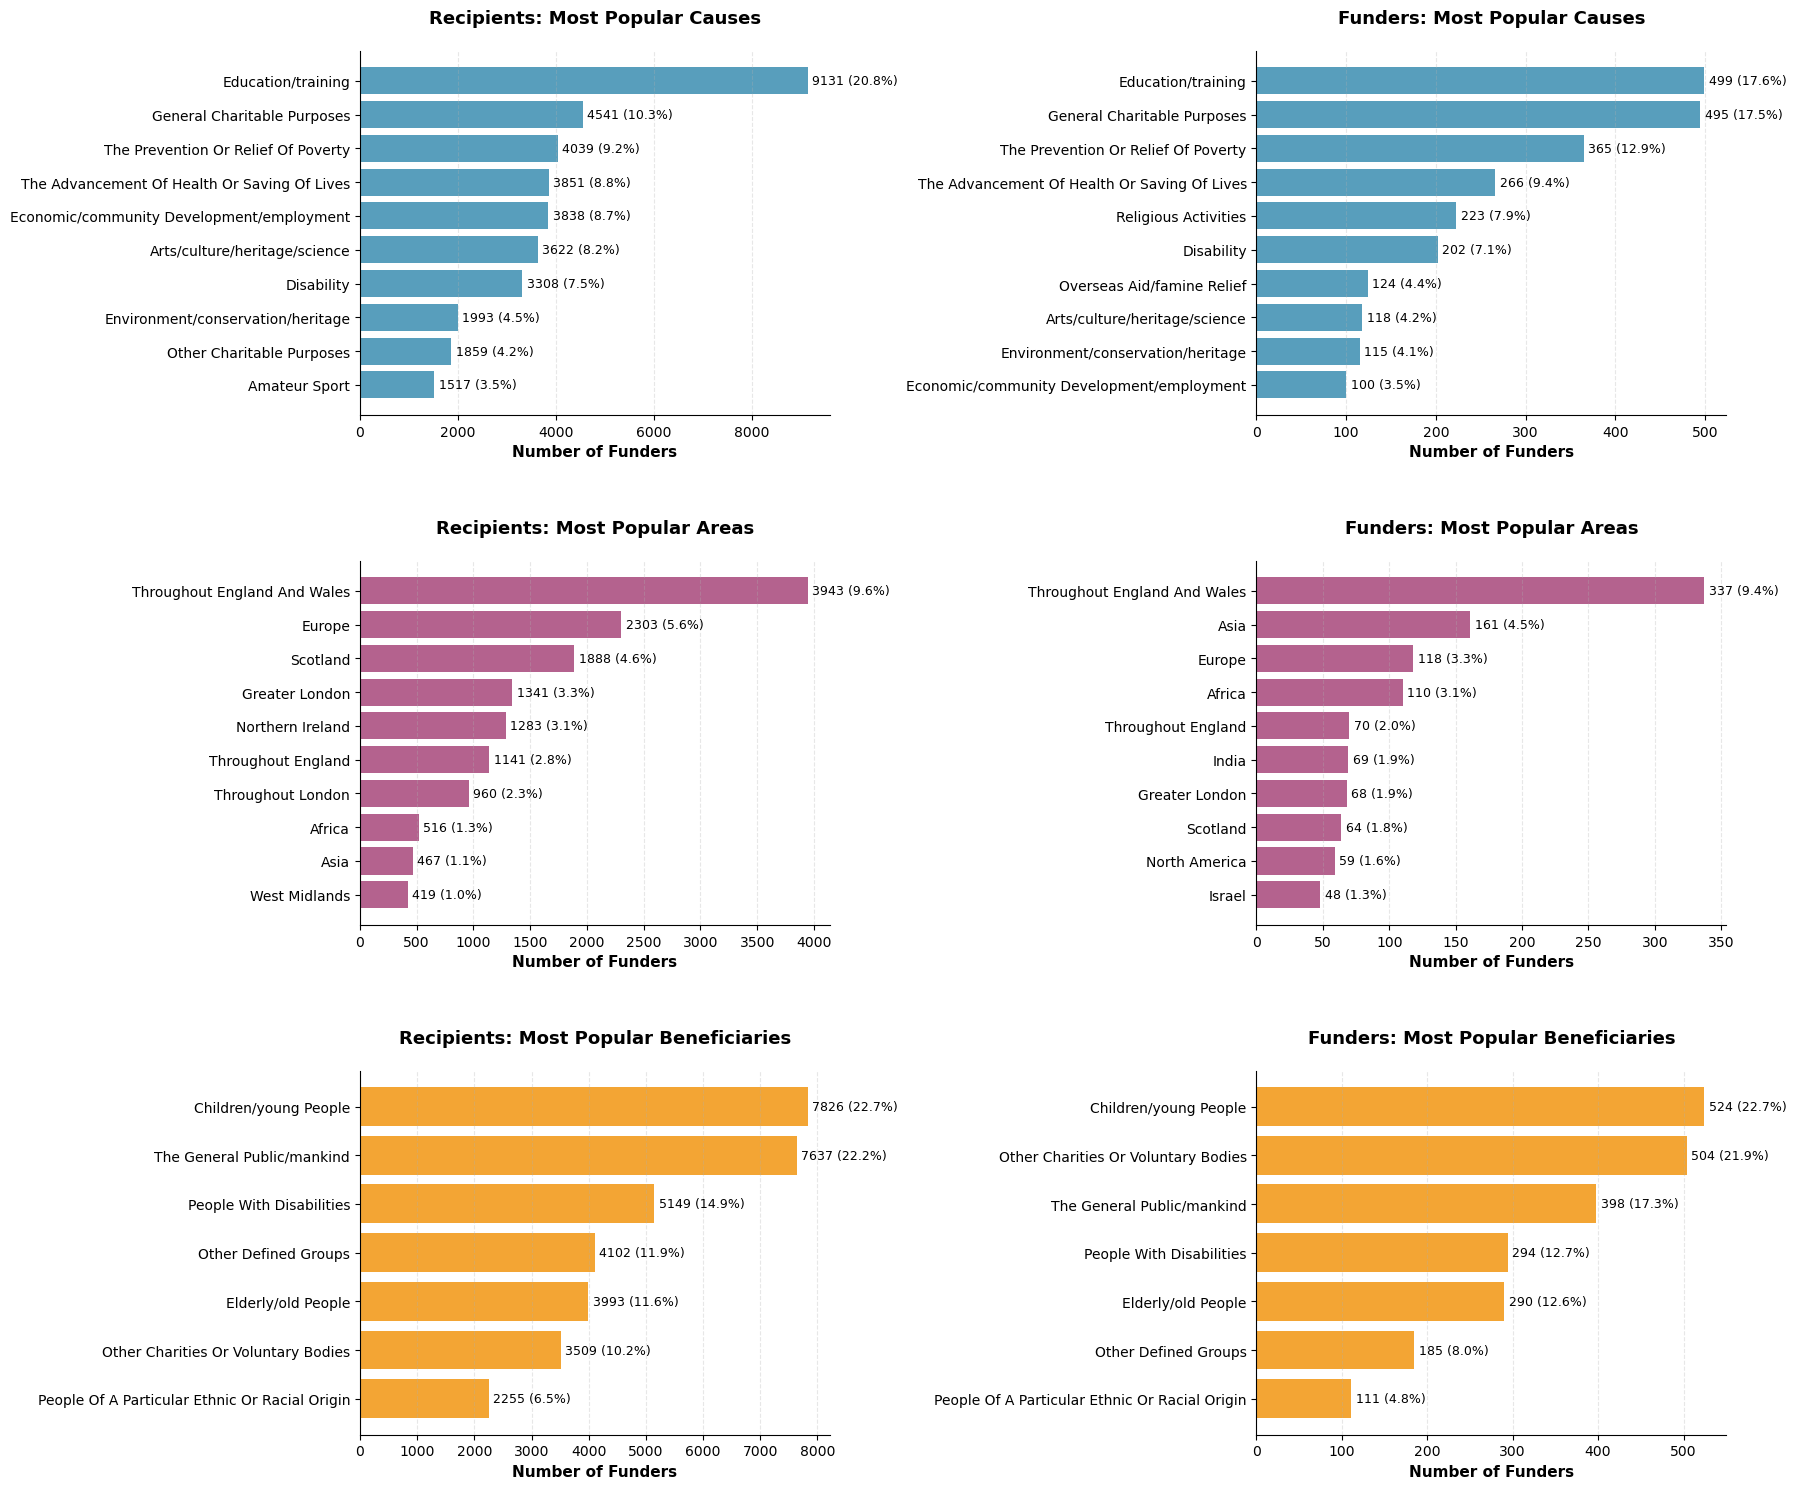

In [66]:
#display plots to compare funders' and recipients' classifications
fig, axes = plt.subplots(3, 2, figsize=(18, 15))

#causes
make_bar_chart(grants_df, "recipient_causes", "Recipients: Most Popular Causes", color="#2E86AB", ax=axes[0, 0])
make_bar_chart(funders_df, "causes", "Funders: Most Popular Causes", color="#2E86AB", ax=axes[0, 1])

#areas
make_bar_chart(grants_df, "recipient_areas", "Recipients: Most Popular Areas", color="#A23B72", ax=axes[1, 0])
make_bar_chart(funders_df, "areas", "Funders: Most Popular Areas", color="#A23B72", ax=axes[1, 1])

#beneficiaries
make_bar_chart(grants_df, "recipient_beneficiaries", "Recipients: Most Popular Beneficiaries", color="#F18F01", ax=axes[2, 0])
make_bar_chart(funders_df, "beneficiaries", "Funders: Most Popular Beneficiaries", color="#F18F01", ax=axes[2, 1])

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

It can be observed that funders often state an interest in general causes, areas and beneficiaries - many do not specify particular interests and state that they will consider applications from any area of the sector. Further analysis will be useful, particularly following the creation of embeddings, to understand the practical reality of their funding priorities, which may reveal implicit preferences or local biases not reflected in their published criteria.

### Relationships between Categories

### Categorical Match Rates

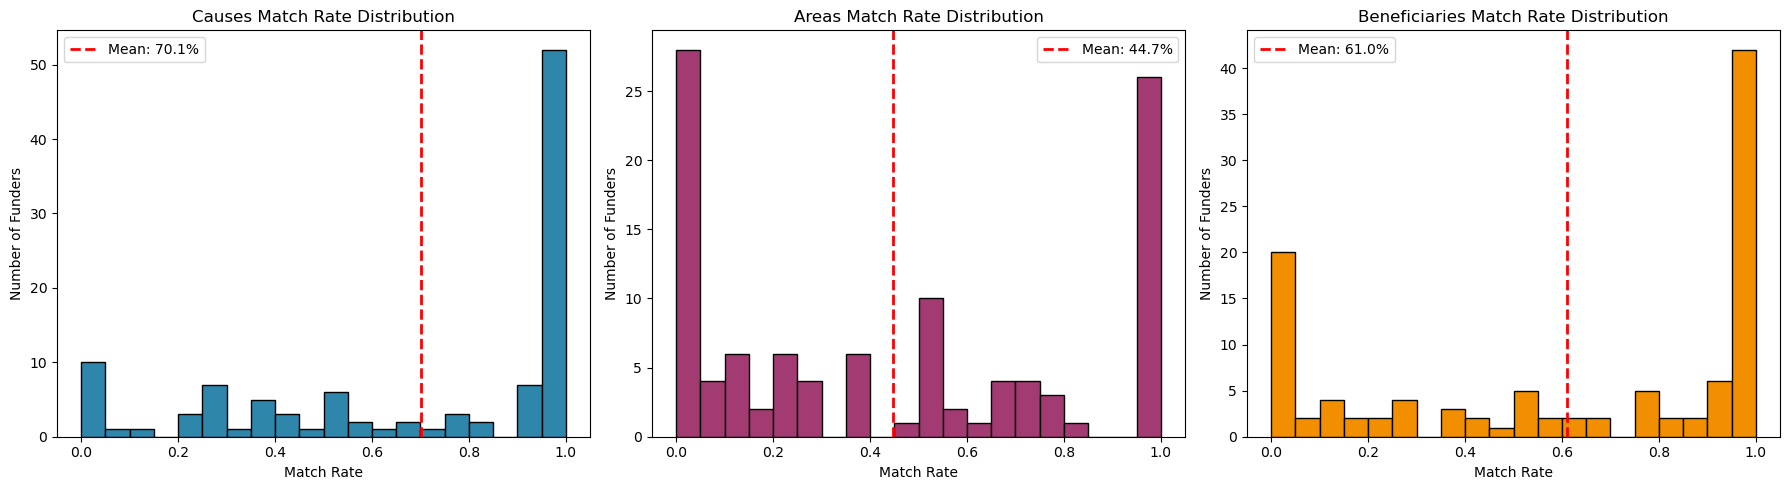

In [67]:
#add funder classifications to grants_df
grants_funders_merge = grants_df.merge(
    funders_df[["registered_num", "causes", "areas", "beneficiaries"]],
    left_on="funder_num",
    right_on="registered_num",
    how="left",
    suffixes=("", "_funder")
)

#find overlaps to identify matches (only where recipeints have classifications)
for category in ["causes", "areas", "beneficiaries"]:
    grants_funders_merge[f'{category}_match'] = grants_funders_merge.apply(lambda row: check_overlap(row[category], row[f'recipient_{category}']), axis=1)

with_classifications = grants_funders_merge[
    (grants_funders_merge["recipient_causes"].str.len() > 0) &
    (grants_funders_merge["recipient_areas"].str.len() > 0) &
    (grants_funders_merge["recipient_beneficiaries"].str.len() > 0)
]

#calculate funder match rates
funder_match_rates = with_classifications.groupby("funder_num").agg({
    "causes_match": ["sum", "mean"],
    "areas_match": ["sum", "mean"],
    "beneficiaries_match": ["sum", "mean"],
    "grant_id": "count"
}).reset_index()

funder_match_rates.columns = ["funder_num", "causes_matches", "causes_match_rate", "areas_matches", "areas_match_rate", "beneficiaries_matches", "beneficiaries_match_rate", "total_grants"]

#add names
funder_match_rates = funder_match_rates.merge(
    funders_df[["registered_num", "name"]],
    left_on="funder_num",
    right_on="registered_num"
)

make_histograms(funder_match_rates)


## 2. Temporal and Financial Analysis

# Exporting Dataframes back to Supabase

In [68]:
funders_df.head(1)

,registered_num,name,website,activities,objectives,income_latest,expenditure_latest,objectives_activities,achievements_performance,grant_policy,is_potential_sbf,is_on_list,causes,areas,beneficiaries,num_grants,total_given,avg_grant,median_grant,income_latest_gbp,expenditure_latest_gbp,total_given_gbp,avg_grant_gbp,median_grant_gbp,income_history,expenditure_history,list_entries,word_count_activities,word_count_objectives,word_count_objectives_activities,word_count_achievements_performance,word_count_grant_policy,short_activities_section,short_objectives_section,short_objectives_activities_section,short_achievements_performance_section,short_grant_policy_section
820,288086,FARRER AND CO CHARITABLE TRUST,https://www.farrer.co.uk,THE MAIN PURPOSE OF THE TRUST IS TO APPLY INCO...,IN OR TOWARDS THE GENERAL PURPOSES OF SUCH CHA...,80569.00,78229.00,None,None,None,False,False,[General Charitable Purposes],[Throughout England And Wales],[Other Charities Or Voluntary Bodies],14,97590.14,6970.72,4000.00,"£80,569.00","£78,229.00","£97,590.14","£6,970.72","£4,000.00","{2020: 78285.0, 2021: 52439.0, 2022: 79299.0, ...","{2020: 76431.0, 2021: 61395.0, 2022: 76795.0, ...",[],36.00,29,NaN,NaN,NaN,False,False,False,False,False


In [69]:
grants_df.head(1)

,grant_title,grant_desc,amount,year,grant_id,funder_num,funder_grants_id,funder_name,recipient_id,recipient_grants_id,recipient_name,recipient_activities,recipient_areas,recipient_causes,recipient_beneficiaries,source,amount_gbp,word_count_grant_title,word_count_grant_desc,word_count_recipient_activities,short_grant_title_section,short_grant_desc_section,short_recipient_activities_section,is_potential_human
0,"""A BLUE NEW DEAL FOR UK COSTAL COMMUNITIES"" PR...","TOWARDS THE COSTS OF THE 'BLUE NEW DEAL', WHIC...",90000.00,2014,360G-Ellerman-15189,263207,44987,JOHN ELLERMAN FOUNDATION,1055254,43799,NEW ECONOMICS FOUNDATION,NEF AIMS TO MAXIMISE WELL-BEING AND SOCIAL JUS...,[Throughout England And Wales],"[Education/training, Economic/community Develo...",[The General Public/mankind],360Giving,"£90,000.00",9.00,21.00,29.00,False,False,False,False


In [70]:
# #get final funder table
# funders_table = funders_df[[
#     "registered_num",
#     "name",
#     "website",
#     "activities",
#     "objectives",
#     "achievements_performance",
#     "grant_policy",
#     "objectives_activities",
#     "income_latest",
#     "expenditure_latest",
#     "is_on_list",
#     "is_potential_sbf"
# ]]

In [71]:
# #get final recipients table
# recipients_table = grants_df[[
#     "recipient_id",
#     "recipient_name",
#     "recipient_activities",
#     "is_recipient"
# ]]

In [72]:
# #get final grants table
# grants_table = grants_df[[
#     "grant_id",
#     "grant_title",
#     "grant_desc",
#     "amount",
#     "year",
#     "source",
#     "is_potential_human"
# ]]